# Calculating Dielectric Function II


part of 

## [Analysis of Transmission Electron Microscope Data](Analysis_of_Transmission_Electron_Microscope_Data.ipynb)

Chapter 4: [Spectroscopy](Diffraction.ipynb)

by Gerd Duscher


# Additional Packages
Now it becomes apparent why I am using ainux system.
Both the Atomic simulation environment (ASE) and the GPAW ( density functional code using the projector-augmented wave (PAW) method ) work only in that environment.

We still import all the usual packages we installed earlier.

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook

# Creates: mac_eps.csv
# Refer to G. Kresse, Phys. Rev. B 73, 045112 (2006)
# for comparison of macroscopic and microscopic dielectric constant
# and absorption peaks.
from ase.build import bulk
from ase.parallel import paropen
from gpaw import GPAW, FermiDirac
from gpaw.response.df import DielectricFunction
import time


import sys
sys.path.append('./TEMlib')
import EELS_tools as eelst         # EELS Library
import file_tools as ft

Populating the interactive namespace from numpy and matplotlib


## Ground state calculation

In [2]:
start_time = time.time()
# Set up of Silicon Crystal
a = 5.431
atoms = bulk('Si', 'diamond', a=a)

# GPAW calculator initialization:
k = 13
calc = GPAW(mode='pw', kpts=(k, k, k),nbands=60)

atoms.set_calculator(calc)
atoms.get_potential_energy()  # ground state calculation is performed
calc.write('Si1.gpw', 'all')  # use 'all' option to write wavefunctions

# Write wavefunctions
end_time = time.time()
print(end_time-start_time)


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  1.5.1
 |___|_|             

User:   nyd@utc
Date:   Thu Apr 25 17:46:56 2019
Arch:   x86_64
Pid:    656
Python: 3.6.6
gpaw:   /home/nyd/.local/lib/python3.6/site-packages/gpaw
_gpaw:  /home/nyd/.local/lib/python3.6/site-packages/
        _gpaw.cpython-36m-x86_64-linux-gnu.so
ase:    /home/nyd/.local/lib/python3.6/site-packages/ase (version 3.17.0)
numpy:  /home/nyd/linux/anaconda3/lib/python3.6/site-packages/numpy (version 1.15.4)
scipy:  /home/nyd/.local/lib/python3.6/site-packages/scipy (version 1.2.1)
units:  Angstrom and eV
cores:  1

Input parameters:
  kpts: [13 13 13]
  mode: pw
  nbands: 60

System changes: positions, numbers, cell, pbc, initial_charges, initial_magmoms 

Initialize ...

Si-setup:
  name: Silicon
  id: b152d83ba7c91a8f3191da15c74e1ae7
  Z: 14
  valence: 4
  core: 10
  charge: 0.0
  file: /usr/share/gpaw-setups/Si.LDA.gz
  cutoffs: 1.06(comp), 1.86(filt), 2.06(core), lmax=2

## Calculating the Dielectric Function

In [3]:
start_time = time.time()

ecut = 50
eshift = 0.8
eta = 0.2

df = DielectricFunction('Si1.gpw',
                        ecut=ecut,
                        frequencies=np.linspace(0., 25., 1001),
                        nbands=8,
                        intraband=False,
                        hilbert=False,
                        eta=eta,
                        eshift=eshift,
                        txt='rpa_Si.txt')

df_NLFC_w, df_LFC_w = df.get_dielectric_function(filename='eps_rpa_Si.csv')
energie = df.get_frequencies()
end_time = time.time()
print(end_time-start_time, 's')

17.226785898208618 s


In [4]:
sim = np.loadtxt('eps_rpa_Si.csv', delimiter=',')

energie = sim[:,0]
df_NLFC_w = sim[:,1]+1j*sim[:,2] 
df_LFC_w = sim[:,3]+1j*sim[:,4] 



# Plotting of Dielectric Function
We have actually calculated the dielectric function in the random phase approximation (RPA) with and without local field corrections.

<IPython.core.display.Javascript object>


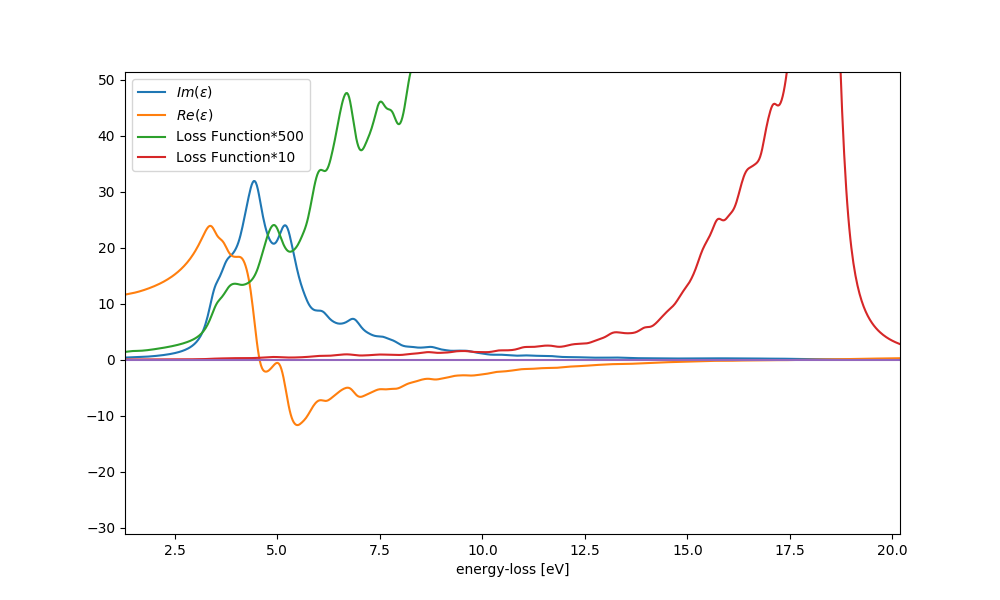

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(energie[0:],df_LFC_w[0:].imag, label=r'$Im(\varepsilon)$' )
plt.plot(energie[0:],df_LFC_w[0:].real, label=r'$Re(\varepsilon)$')
plt.plot(energie, (-1/df_LFC_w).imag*500, label='Loss Function*500')
plt.plot(energie, (-1/df_LFC_w).imag*10, label='Loss Function*10')
plt.plot([0,70],[0,0])
plt.legend()
plt.xlim(0,20);
plt.ylim(-15,50);
plt.xlabel('energy-loss [eV]');



## Comparison to previous Silicon EELS spectrum

Found  EELS_spectrum  in dm3 file


<IPython.core.display.Javascript object>


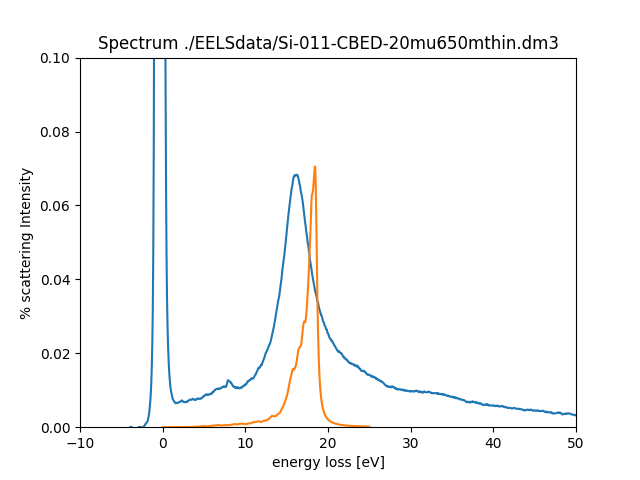

In [6]:

filename = './EELSdata/Si-011-CBED-20mu650mthin.dm3'
spectrum_tags = ft.open_file(filename)#os.path.join(current_directory,filename))

spectrum_tags['axis']['0']['pixels'] = len(spectrum_tags['spec'])

scale_p = spectrum_tags['axis']['0']
spectrum_tags['energy_scale'] = np.arange(scale_p['pixels'])*scale_p['scale']+scale_p['Origin']

energy_scale = spectrum_tags['energy_scale'] 
spectrum = spectrum_tags['spec']

#######################################
## Important Experimental Parameters ##
#######################################

spectrum_tags['eels_parameter'] = {}
spectrum_tags['eels_parameter']['integration_time_s'] = spectrum_tags['integration_time']
spectrum_tags['eels_parameter']['number_of_frames'] = spectrum_tags['number_of_frames']
spectrum_tags['eels_parameter']['acceleration_voltage_V'] = spectrum_tags['acceleration_voltage']
spectrum_tags['eels_parameter']['collectionAngle_mrad'] =50.
spectrum_tags['eels_parameter']['convergenceAngle_mrad'] =30.
spectrum_tags['eels_parameter']['integration_time'] = spectrum_tags['integration_time']

eels_p = spectrum_tags['eels_parameter']

sumSpec = sum(spectrum_tags['spec'])

plt.figure()
plt.plot(energy_scale,spectrum/sumSpec*1e2)
plt.plot(energie, (-1/df_LFC_w).imag/160, label='Loss Function*10')
plt.title ('Spectrum '+spectrum_tags['filename']);
plt.xlabel('energy loss [eV]')
plt.ylabel('% scattering Intensity');
plt.xlim(-10,50)
plt.ylim(0,.1);

## Comparison to optical data

<IPython.core.display.Javascript object>


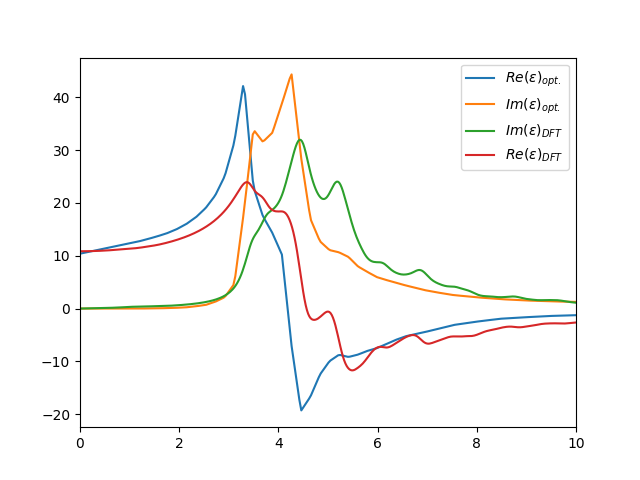

In [9]:
opt_data = np.loadtxt('./EELSdata/KroegerEBplots_Si.dat')

plt.figure()
plt.plot(opt_data[:,0],opt_data[:,1], label=r'$Re(\varepsilon)_{opt.}$')
plt.plot(opt_data[:,0],opt_data[:,2],  label=r'$Im(\epsilon)_{opt.}$' )
plt.plot(energie[0:],df_LFC_w[0:].imag, label=r'$Im(\epsilon)_{DFT}$' )
plt.plot(energie[0:],df_LFC_w[0:].real, label=r'$Re(\varepsilon)_{DFT}$')
plt.xlim(0,10)
plt.legend();


# A More Involved Calculation

<IPython.core.display.Javascript object>


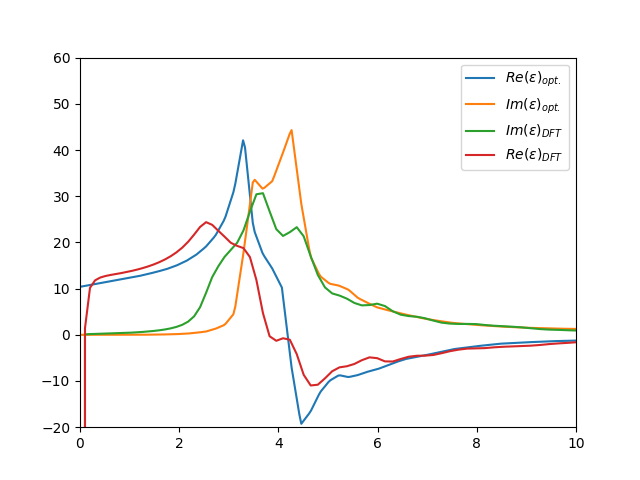

In [10]:
data = np.loadtxt('epsSi.csv', delimiter=',')

epsSi_NLF = data[:,1]+1j*data[:,2]
epsSi_LF = data[:,3]+1j*data[:,4]
epsSi_energy = data[:,0]
plt.figure()
plt.plot(opt_data[:,0],opt_data[:,1], label=r'$Re(\varepsilon)_{opt.}$')
plt.plot(opt_data[:,0],opt_data[:,2],  label=r'$Im(\epsilon)_{opt.}$' )
plt.plot(epsSi_energy,epsSi_LF[0:].imag, label=r'$Im(\epsilon)_{DFT}$' )
plt.plot(epsSi_energy,epsSi_LF[0:].real, label=r'$Re(\varepsilon)_{DFT}$')
plt.xlim(0,10)
plt.ylim(-20,60)
plt.legend();


<IPython.core.display.Javascript object>


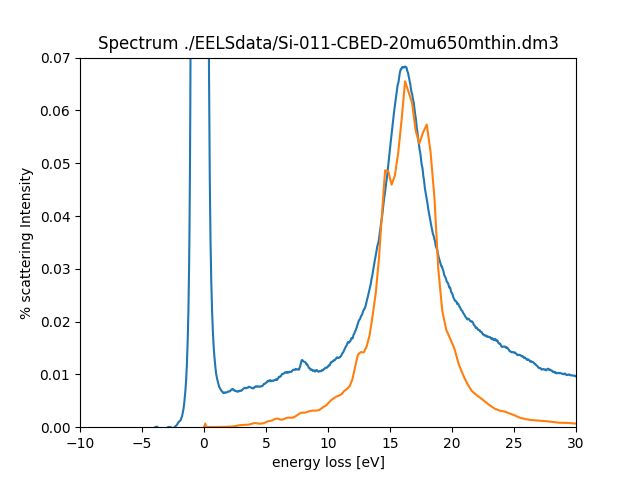

In [11]:
plt.figure()
plt.plot(energy_scale,spectrum/sumSpec*1e2)
plt.plot(epsSi_energy, (-1/epsSi_LF).imag/60, label='Loss Function*10')
plt.title ('Spectrum '+spectrum_tags['filename']);
plt.xlabel('energy loss [eV]')
plt.ylabel('% scattering Intensity');
plt.xlim(-10,30)
plt.ylim(0,.07);

## Back:[Calculating Dielectric Functions I](DielectricDFT.ipynb)


## Chapter 4: [Spectroscopy](Spectroscopy.ipynb)
## Index: [Index](Analysis_of_Transmission_Electron_Microscope_Data.ipynb)